In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Total 3435 (delta 0), reused 0 (delta 0), pack-reused 3435
Receiving objects: 100% (3435/3435), 641.56 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (1975/1975), done.
Updating files: 100% (222/222), done.


In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
 
if image_path.is_dir():
else:
    image_path.mkdir(parents=True, exist_ok=True)
    

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)


    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)


    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, 
                                                                               batch_size=32) 

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f563043bca0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model;

In [12]:
print(weights)

EfficientNet_B0_Weights.IMAGENET1K_V1


In [13]:
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [14]:
for param in model.features.parameters():
    param.requires_grad = False

In [15]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


output_shape = len(class_names)


model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True)).to(device)

In [17]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3181 | train_acc: 0.9336 | test_loss: 0.3623 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.2960 | train_acc: 0.9609 | test_loss: 0.3584 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.2962 | train_acc: 0.9570 | test_loss: 0.3723 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.3067 | train_acc: 0.9844 | test_loss: 0.3658 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.2642 | train_acc: 0.9766 | test_loss: 0.3856 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3202 | train_acc: 0.9766 | test_loss: 0.3572 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.2843 | train_acc: 0.9766 | test_loss: 0.3463 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3138 | train_acc: 0.8555 | test_loss: 0.3645 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8281 | test_loss: 0.3586 | test_acc: 0.9489
Epoch: 10 | train_loss: 0.3265 | train_acc: 0.8398 | test_loss: 0.3139 | test_acc: 0.8759
[INFO] Total training time: 24.526 seconds


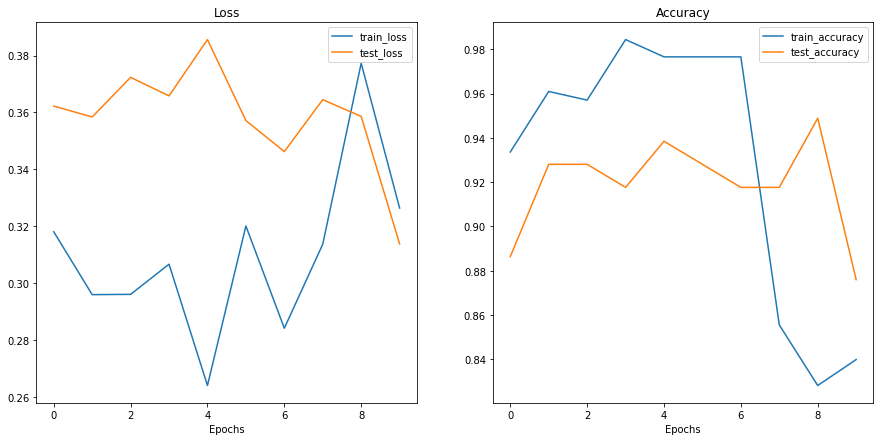

In [23]:
try:
    from helper_functions import plot_loss_curves
except:
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves


plot_loss_curves(results)

In [24]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    img = Image.open(image_path)


    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])



    model.to(device)


    model.eval()
    with torch.inference_mode():

      transformed_image = image_transform(img).unsqueeze(dim=0)


      target_image_pred = model(transformed_image.to(device))


    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)


    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

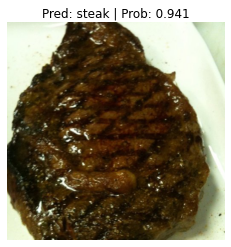

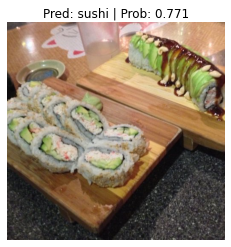

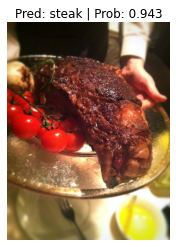

In [25]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

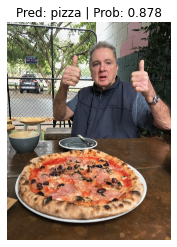

In [26]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)